In [2]:
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from lightning_models import ForecastLSTM
from torchinfo import summary

In [3]:
model = ForecastLSTM(data_path = 'Dataset\IKCO1.csv',
                        split = [0.70, 0.15, 0.15],
                        batch_size = 128,       
                        learning_rate = 3e-4,
                        weight_decay = 0.001,
                        input_size = 5,
                        hidden_size = 256,
                        hidden_layer_size = 64,
                        k_days = 30,
                        num_layers = 3,
                        prob = 0,
                        timestep = 90,)


summary(model, input_size = (128, 90, 5))

Layer (type:depth-idx)                   Output Shape              Param #
ForecastLSTM                             --                        --
├─forecastLSTM: 1-1                      [128, 30]                 --
│    └─LSTM: 2-1                         [128, 90, 256]            1,321,984
│    └─Linear: 2-2                       [128, 64]                 16,448
│    └─Linear: 2-3                       --                        (recursive)
│    └─Dropout: 2-4                      [128, 64]                 --
│    └─Linear: 2-5                       [128, 30]                 1,950
Total params: 1,340,382
Trainable params: 1,340,382
Non-trainable params: 0
Total mult-adds (G): 15.23
Input size (MB): 0.23
Forward/backward pass size (MB): 23.69
Params size (MB): 5.36
Estimated Total Size (MB): 29.28

In [29]:
checkpoint_callback = ModelCheckpoint(dirpath = 'lstmpredictor',
                                    filename = "my_checkpoint.ckpt",
                                    every_n_epochs = 1,
                                    monitor = 'val_loss',
                                    mode = 'min')

early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00,
                                    patience = 8,
                                    verbose = False,
                                    mode = "min")

logger = TensorBoardLogger('lstmpredictor-logs/', name = 'lstmpredictor', version = 0)

In [30]:
trainer = Trainer(
    default_root_dir = 'lstmpredictor-logs/',
    gpus = (1 if torch.cuda.is_available() else 0),
    callbacks = [checkpoint_callback, early_stop_callback],
    max_epochs = 100,
    logger = logger)

trainer.fit(model = model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Anaconda\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\Yegyanathan V\Desktop\Python\Deep Learning\AE-LSTM\lstmpredictor exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type              | Params
----------------------------------------------------------
0 | model               | forecastLSTM      | 1.3 M 
1 | loss                | MSELoss           | 0     
2 | mean_absolute_error | MeanAbsoluteError | 0     
3 | mean_squared_error  | MeanSquaredError  | 0     
----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.362     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  30%|███       | 3/10 [00:05<00:12,  1.84s/it, loss=0.254, v_num=0]

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
trainer.test(datamodule = model)

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:412: LightningDeprecationWarning: `LightningDataModule.on_save_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `state_dict` instead.
  rank_zero_deprecation(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:417: LightningDeprecationWarning: `LightningDataModule.on_load_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `load_state_dict` instead.
  rank_zero_deprecation(
Restoring states from the checkpoint path at C:\Users\Yegyanathan V\Desktop\Python\De

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           MAE             0.012009894475340843
           MSE            0.00021508801728487015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'MAE': 0.012009894475340843, 'MSE': 0.00021508801728487015}]

In [16]:
from utils import train_val_test_split, return_based, log_return_based, returns_direction

model = model.load_from_checkpoint("lstmpredictor\my_checkpoint.ckpt.ckpt")

df = pd.read_csv('Dataset\PARK1.csv', index_col = [0])

df['<CLOSE>_rb'] = pd.DataFrame(return_based(df['<CLOSE>'], 21))
df['<OPEN>_rb'] = pd.DataFrame(return_based(df['<OPEN>'], 21))
df['<HIGH>_rb'] = pd.DataFrame(return_based(df['<HIGH>'], 21))
df['<LOW>_rb'] = pd.DataFrame(return_based(df['<LOW>'], 21))
df['<VOL>_rb'] = pd.DataFrame(log_return_based(df['<VOL>'], 21))

df['returns'] = pd.DataFrame(returns_direction(df))

df[['returns']] = df[['returns']].rolling(90).median()
df[21:]

input = df[['<OPEN>_rb', '<HIGH>_rb', '<LOW>_rb', '<CLOSE>_rb', '<VOL>_rb']][-90:]
input = model.scaler_X.transform(input)
input = np.array(input).astype(np.float32)
input = input.reshape(1, input.shape[0], input.shape[1])

input = torch.tensor(input)
input

tensor([[[0.1797, 0.1073, 0.1862, 0.1449, 0.3570],
         [0.1449, 0.1079, 0.1534, 0.1330, 0.4011],
         [0.1330, 0.1072, 0.1451, 0.1575, 0.4026],
         [0.1575, 0.1302, 0.2288, 0.2029, 0.4014],
         [0.2029, 0.1474, 0.1974, 0.1750, 0.3561],
         [0.1750, 0.1413, 0.1755, 0.1676, 0.3726],
         [0.1676, 0.0949, 0.1569, 0.1334, 0.4330],
         [0.1334, 0.0817, 0.1494, 0.1015, 0.4718],
         [0.1015, 0.0880, 0.1749, 0.1374, 0.3388],
         [0.1374, 0.1104, 0.2154, 0.1931, 0.3680],
         [0.1931, 0.1427, 0.1995, 0.2350, 0.4778],
         [0.2350, 0.1599, 0.2342, 0.2028, 0.4305],
         [0.2028, 0.1329, 0.2180, 0.2006, 0.4736],
         [0.2006, 0.1462, 0.2328, 0.2312, 0.4374],
         [0.2312, 0.1727, 0.2882, 0.2608, 0.4809],
         [0.2608, 0.1944, 0.2776, 0.2412, 0.4476],
         [0.2412, 0.1601, 0.2429, 0.2116, 0.4287],
         [0.2116, 0.1590, 0.2241, 0.2499, 0.4538],
         [0.2499, 0.1848, 0.3388, 0.2937, 0.3793],
         [0.2937, 0.2268, 0.333

In [17]:
model.eval()
with torch.no_grad():
    
    output = model(torch.tensor(input)) 

preds = output.squeeze()
preds = np.array(preds) 
preds

C:\Users\YEGYAN~1\AppData\Local\Temp/ipykernel_10308/984439999.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(input))


array([0.49802697, 0.49942574, 0.49296653, 0.49376917, 0.4960452 ,
       0.49912956, 0.49981272, 0.49291053, 0.49412113, 0.49694726,
       0.491881  , 0.49617913, 0.492989  , 0.49260783, 0.49201137,
       0.4933931 , 0.4925306 , 0.49906436, 0.49735233, 0.49291903,
       0.4948292 , 0.49970123, 0.4997473 , 0.49620372, 0.49600554,
       0.4919779 , 0.4994794 , 0.4986123 , 0.49944496, 0.49252653],
      dtype=float32)

In [18]:
preds.shape

(30,)

In [19]:
preds = pd.DataFrame(preds, columns = ['returns'])
preds[['returns']] = model.scaler_y.inverse_transform(preds[['returns']])
preds

,returns
0,51.663609
1,58.282597
2,27.717632
3,31.515705
4,42.285896
5,56.881096
6,60.113804
7,27.452646
8,33.181206
9,46.554428


<AxesSubplot:>

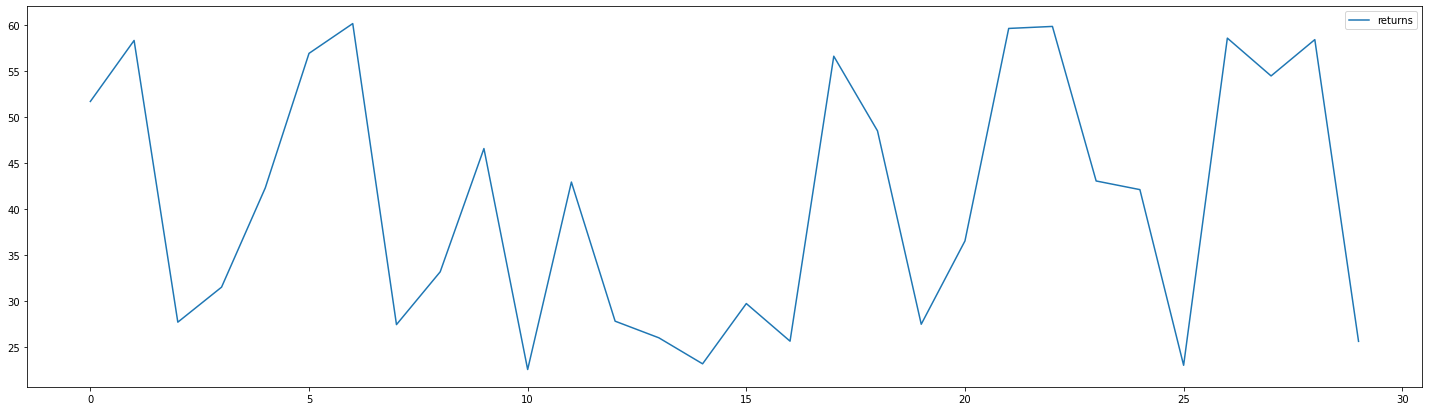

In [20]:
preds.plot(figsize = (25, 7))

Text(0.5, 0, 'Day Count')

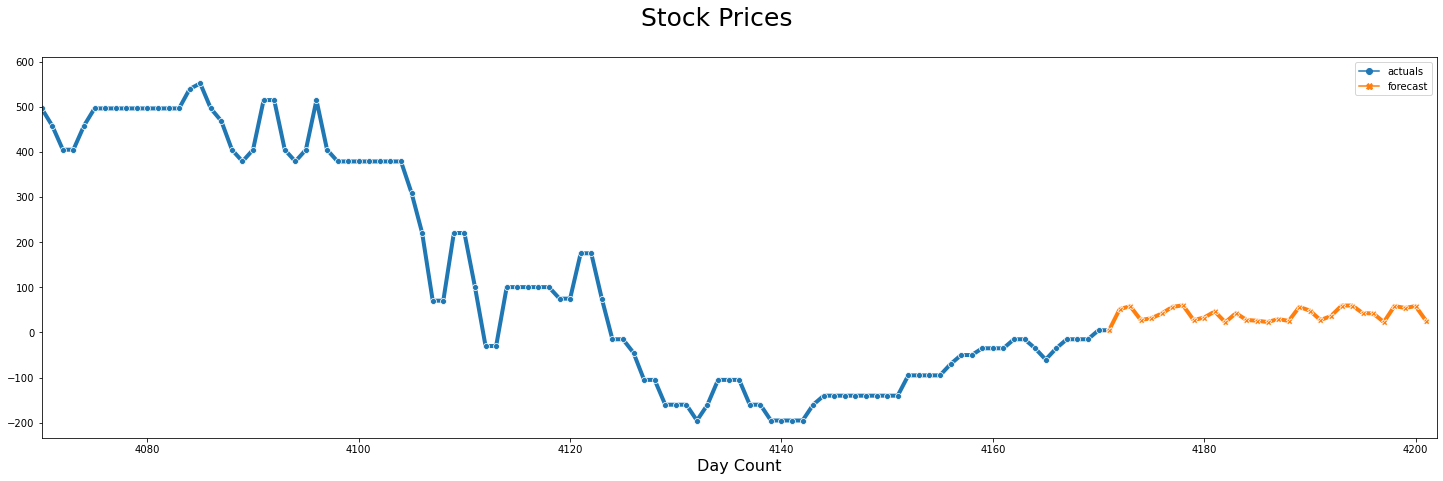

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

my_df = pd.DataFrame()

actuals = df['returns']

list = [np.nan for i in range(len(df) - 1)]
list.append(actuals[len(actuals) - 1])

for i in range(30):
    actuals = actuals.append(pd.Series(pd.NA), ignore_index=True)

my_df['actuals'] = actuals
my_df['actuals'] = pd.to_numeric(my_df['actuals'])

target_series = preds['returns']

for x in target_series:
    list.append(x)

my_df['forecast'] = pd.Series(list)
my_df.loc[len(df) - 1, 'forecast'] = actuals[len(df) - 1]


fig = plt.figure(figsize=(25, 7))
sns.lineplot(data = my_df, markers = True, dashes = False, linewidth = 4)
sns.color_palette("flare", as_cmap=True)
plt.xlim([4070, len(my_df)]) #len(my_df) - next_k_days - 10
fig.suptitle('Stock Prices', fontsize = 25)
plt.xlabel('Day Count', fontsize = 16)